# Stroke Predictor Using Various Factors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import confusion_matrix

## Data Import and Cleaning

In [2]:
#loading dataa
patient_data = pd.read_csv('train_datalabel.csv')
test = pd.read_csv('test_data.csv')
submission = pd.read_csv('sample_submission.csv')


# creating a validation set
patient_train, patient_validation = train_test_split(patient_data, 
                                             test_size = .25, 
                                             random_state = 0)

In [3]:
#Check if there exists N/A values in the dataframes here. 
#Think about how you could handing missing values.
#Modify the dataframe here as you see fit.

# we could replace the values with the means
def replace_nan(df):
    df = one_hot_encode(df)
    no_nan_df = without_nan(df)
    vals = {column: np.average(no_nan_df[column]) for column in no_nan_df}
    df = df.drop('id', axis = 1)
    return df.fillna(value = vals)


#this code removes all rows that contain N/A values
def without_nan(df):
    not_nan = df.notna()
    rows_no_nan = not_nan.all(axis=1)
    return df[rows_no_nan]

In [4]:
def standardize(dataframe_column):
    """
    This function converts a column in a dataframe into standard units"
    dataframe_column(array): the column as an array
    
    returns an array of standardized numbers
    """
    return (dataframe_column - np.mean(dataframe_column)) / np.std(dataframe_column)

## One Hot Encoding

In [5]:
#Since there are categorical variables here, do can apply one hot encoding to categorical columns!
#You can also use other techniques too if you wish.
#REMEMBER TO APPLY THE SAME TRANSFORMATION TO BOTH TRAINING AND TESTDATA.

def one_hot_encode(df):
    df = pd.get_dummies(df, columns=["gender", "ever_married", "work_type", "Residence_type", "smoking_status"])
    return df


## MODEL 1: Data Visualization

This section is just for playing around with visualizations and seeing what potential correlations there might be.

My first idea is to divide our train set into two categories: those who have experienced a stroke and those who haven't. Then, we find the mean age, hypertension, etc. for both categories and see if there are any notable differences.

In [6]:
def compare_vars(dataframe, variable):
    '''Takes a cleaned train dataframe and separates it into 2 datasets.
        One dataset for stroke patients, one dataset for non-stroke patients.
        It will then find the mean for the variable passed in for both datasets
        dataframe = df
        variable = str'''
    has_stroke = dataframe[dataframe['stroke'] == 1]
    no_stroke = dataframe[dataframe['stroke'] == 0]
    stroke_mean = np.mean(has_stroke[variable])
    no_stroke_mean = np.mean(no_stroke[variable])
    print('Stroke mean' + '('+variable+'): ' + str(stroke_mean))
    print('No mean' + '('+variable+'):'+ str(no_stroke_mean))

In [7]:
# TO CHRIS: I will try to put the differences between each variable here
def compute_diffs(dataframe, variable):
    '''Takes a cleaned train dataframe and separates it into 2 datasets.
        One dataset for stroke patients, one dataset for non-stroke patients.
        It will then find the mean for the variable passed in for both datasets
        and print the difference between each mean. a positive value indicates higher values
        for stroke people
        dataframe = df
        variable = str'''
    has_stroke = dataframe[dataframe['stroke'] == 1]
    no_stroke = dataframe[dataframe['stroke'] == 0]
    stroke_mean = np.mean(has_stroke[variable])
    no_stroke_mean = np.mean(no_stroke[variable])
    print(variable + ' diff: ' + str(stroke_mean - no_stroke_mean))

In [8]:
factors_to_standardize = ['age', 'avg_glucose_level', 'bmi']
for i in factors_to_standardize:
    patient_train[i] = standardize(patient_train[i])
    patient_validation[i] = standardize(patient_validation[i])

patient_train['age'] = patient_train['age']
patient_validation['age'] = patient_validation['age']

/var/folders/gh/k7rgm7qs3zl2lw8bn_ydlg_40000gq/T/ipykernel_48410/2474148539.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_train[i] = standardize(patient_train[i])
/var/folders/gh/k7rgm7qs3zl2lw8bn_ydlg_40000gq/T/ipykernel_48410/2474148539.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_validation[i] = standardize(patient_validation[i])
/var/folders/gh/k7rgm7qs3zl2lw8bn_ydlg_40000gq/T/ipykernel_48410/2474148539.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [9]:
heatmap_corr = pd.get_dummies(patient_data, columns=['ever_married'])

<AxesSubplot:>

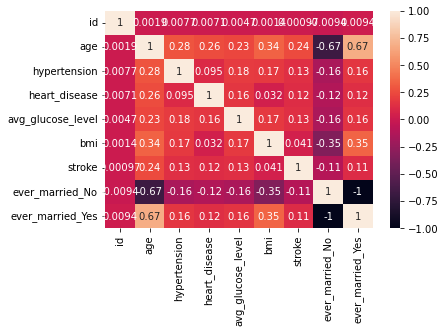

In [10]:
sns.heatmap(data = heatmap_corr.corr(), annot= True)

In [11]:
"""
These are the findings we made from observing our data

higher for stroke people:
age
hypertension
heart disease
glucose level
bmi
married
self-employed
rural living situation
formerly smoked / smokes
men are more likely
"""

'\nThese are the findings we made from observing our data\n\nhigher for stroke people:\nage\nhypertension\nheart disease\nglucose level\nbmi\nmarried\nself-employed\nrural living situation\nformerly smoked / smokes\nmen are more likely\n'

In [12]:
patient_train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1733,19550,Male,-0.184119,0,0,Yes,Private,Urban,2.471439,1.314926,never smoked,0
1861,29694,Female,1.091434,0,0,Yes,Private,Rural,-0.255074,-0.924436,smokes,0
4055,71957,Female,-0.360057,0,0,Yes,Private,Rural,-1.071312,1.377131,smokes,0
2668,5236,Female,0.255727,0,0,Yes,Private,Rural,-0.742500,0.506268,never smoked,0
3903,60562,Female,-0.975842,0,0,No,Private,Rural,-1.151510,-0.887114,never smoked,0


## Bootstrap

In [13]:
#making a copy of patient_data
initial_boot = patient_data.copy()
initial_boot = replace_nan(initial_boot)
#filtering for just positive stroke == 1
just_strokes = initial_boot[initial_boot['stroke'] == 1]

bootstrap_1 = just_strokes.sample(200, replace = True)
bootstrap_1

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
105,76.0,0,0,140.10,29.9,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
94,58.0,0,0,59.86,28.0,1,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
188,68.0,0,0,211.06,39.3,1,1,0,0,0,...,0,1,0,0,1,0,1,0,0,0
77,81.0,0,1,78.70,19.4,1,1,0,0,0,...,0,0,1,0,1,0,1,0,0,0
169,79.0,0,1,205.33,31.0,1,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,78.0,0,0,78.03,23.9,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
39,79.0,0,1,127.29,27.7,1,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
196,14.0,0,0,57.93,30.9,1,1,0,0,1,...,0,0,0,1,1,0,1,0,0,0
121,57.0,0,0,221.89,37.3,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1


In [14]:
patient_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4083,22127,Female,18.0,0,0,No,Private,Urban,82.85,46.9,Unknown,0
4084,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
4085,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
4086,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0


In [15]:
data = replace_nan(patient_data)
np.average(data['ever_married_No'] * data['stroke'])

0.00611545988258317

In [16]:
def bootstrap(dataframe):
    '''Takes a cleaned dataframe of just stroke == 1 and bootstraps it
    '''
    df = dataframe.sample(200, replace = True)
    return df

In [17]:
for i in np.arange(19):
    new_boot = bootstrap(just_strokes)
    bootstrap_1 = bootstrap_1.append(new_boot)

len(bootstrap_1.index)

4000

In [18]:
# FINAL bootstrapped dataset, both class sizes should be roughly equal
final_patient_data = initial_boot.append(bootstrap_1)
len(final_patient_data)

8088

# Random Forest

For random forest, standardization does not matter and weighing does not matter either ; just throw in every possible feature because the random forest will weed out the ones that don't matter

In [19]:
forest_factors = ["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "gender_Male", "ever_married_Yes", "work_type_Self-employed", "Residence_type_Rural", "smoking_status_never smoked"]

In [20]:
# ensures that we have an unaltered table

patient_train, patient_validation = train_test_split(final_patient_data, 
                                             test_size = .25, 
                                             random_state = 0)


In [21]:
# JOE: I'll play around with weighting here
for column in factors_to_standardize:
    patient_train[column] = standardize(patient_train[column])
    patient_validation[column] = standardize(patient_validation[column])

/var/folders/gh/k7rgm7qs3zl2lw8bn_ydlg_40000gq/T/ipykernel_48410/1770486400.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_train[column] = standardize(patient_train[column])
/var/folders/gh/k7rgm7qs3zl2lw8bn_ydlg_40000gq/T/ipykernel_48410/1770486400.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_validation[column] = standardize(patient_validation[column])


In [22]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 736,
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_features = 'sqrt',
    max_depth = None,
    bootstrap = False)

# now, I'm going to clean the data. We remove all irrelevant columns
patient_train_y = patient_train["stroke"]
#patient_train_x = patient_train[forest_factors]
patient_train_x = patient_train.drop(["stroke", "gender_Other"], axis=1)

model.fit(patient_train_x, patient_train_y)
forest_predictions = model.predict(patient_train_x)

# this shows the accuracy of the random forest
(forest_predictions == patient_train_y).sum() / patient_train_y.shape[0]    

1.0

In [23]:
#Measure the performance of your model on the validation set and report the error by printing out the loss.
patient_validation_y = patient_validation["stroke"]
#patient_validation_x = patient_validation[forest_factors]
patient_validation_x = patient_validation.drop(["stroke", "gender_Other"], axis=1)
validation_forest_predictions = model.predict(patient_validation_x)
(validation_forest_predictions == patient_validation_y).sum() / patient_validation_y.shape[0]


0.990108803165183

## Hyperparameter tuning

In [24]:
# this is parameter tuning

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [736, 737] 

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [None]

# Minimum number of samples required to split a node
min_samples_split = [2]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1]

# Method of selecting samples for training each tree
bootstrap = [False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [25]:
rf = RandomForestRegressor()

hypertuning_obj = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

hypertuning_obj.fit(patient_train_x, patient_train_y)

hypertuning_obj.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/joez/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_estimators': 736,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

The best parameters for our random forest are: 

{'n_estimators': 736, 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

# Submission

In [26]:
#Predict test data labels using your model here. 
#Your output should be of length 1022

test_data = pd.read_csv('test_data.csv')
clean_test_data = replace_nan(test)

preds_for_submission = model.predict(clean_test_data)

In [27]:
#change the stroke column of submission variable I definied above to your test predictions.

submission["stroke"] = preds_for_submission

In [28]:
#Saving the csv file
#You can download this file by going to the output folder on the right side of your screen. 
# The csv is in /kaggle/working
submission.to_csv('submission.csv', index=False)